Importa bibliotecas

In [19]:
import graph_tool_extras as gte
import pandas as pd
import csv
from graph_tool import centrality
from math import sqrt
from statistics import mean
from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

Importa a base de dados

In [20]:
PATH = './USvideos.csv'
data = pd.read_csv(PATH)

In [21]:
data.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [22]:
def formata_tag(tag_string):
    # Remove espaços extras e divide pelo separador "|"
    tags = tag_string.strip().split("|")
    
    # Remove aspas extras caso existam
    tags = [tag.strip('"') for tag in tags]
    
    # Retorna as tags no formato desejado
    return tags

In [23]:
dic = {}
with open(PATH) as file:
    reader = csv.reader(file)

    # Ignora a primeira linha, pois ela é o cabeçalho.
    next(reader)

    # Lê o arquivo linha por linha, sem carregá-lo inteiro na memória.
    for line in reader:

        key = line[0] #USA O ID COMO CHAVE

        tags = formata_tag(line[6])
        
        # Neste caso, vamos guardar as informações em dicionário. Lembre que,
        # dependendo do caso, a memória do seu computador pode não aguentar.
        dic[key] = tags

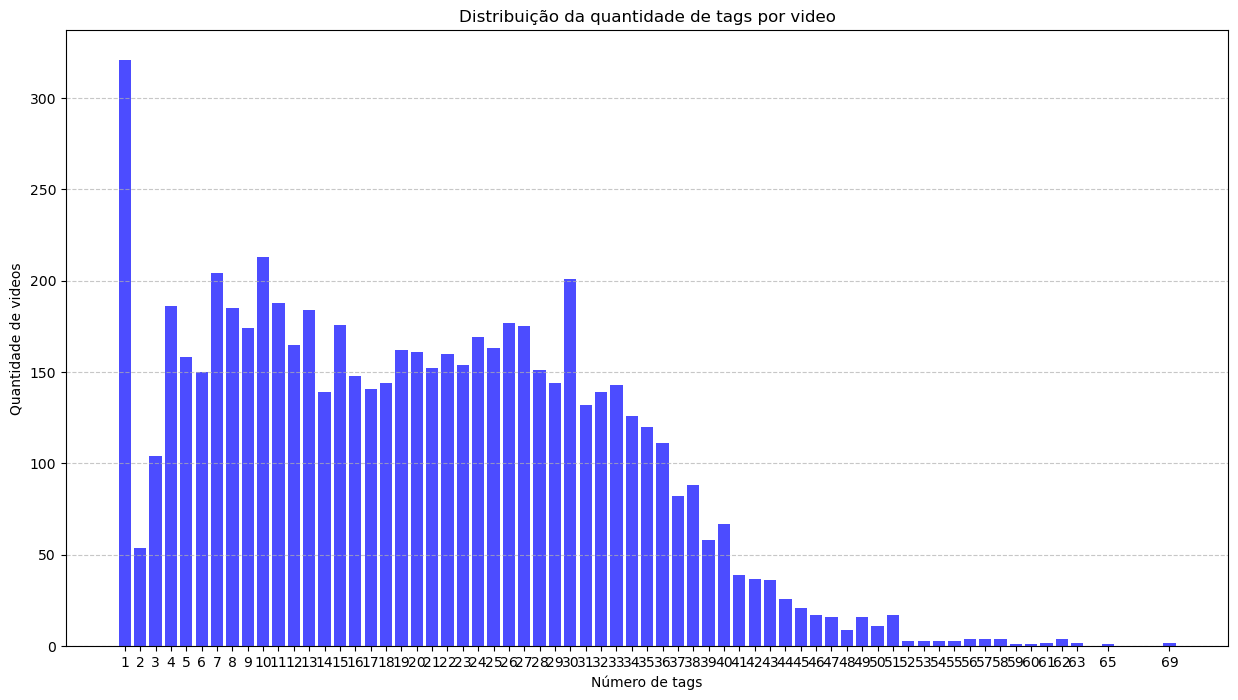

Média da quantidade de tags por vídeo: 19.96000629822075


In [24]:
contador_tag_video = Counter()
for u in dic.keys():
    n = len(dic[u])
    contador_tag_video[n] += 1

x_values = sorted(contador_tag_video.keys())
y_values = [contador_tag_video[x] for x in x_values]

# Criar gráfico
plt.figure(figsize=(15, 8))
plt.bar(x_values, y_values, color='b', alpha=0.7)
plt.xlabel("Número de tags")
plt.ylabel("Quantidade de videos")
plt.title("Distribuição da quantidade de tags por video")
plt.xticks(x_values)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

media_tags_por_video = np.average(x_values, weights=y_values)

print("Média da quantidade de tags por vídeo:", media_tags_por_video)

#### Pegamos somente videos que possuem mais de 40 tags

In [25]:
dic = {k: v for k, v in dic.items() if len(v) > 40}

#### Adicionando os vértices

In [26]:
g = gte.Graph(directed=False)
tags_adicionadas = set()
# As chaves de um dicionário são naturalmente únicas.
# Não precisamos nos preocupar se o id já existe.
vertices = 0
arestas = 0
for u in dic.keys():
    for tag in dic[u]:
        if tag not in tags_adicionadas:
            try:
                g.add_vertex_by_id(tag)
                tags_adicionadas.add(tag)  # Marca como adicionado
                vertices += 1
            except KeyError:
                # Se já existe, apenas continue
                pass  

print(f"Vertices (tags): {vertices}")

Vertices (tags): 7479


#### Gráfico numero de videos com tags em comum

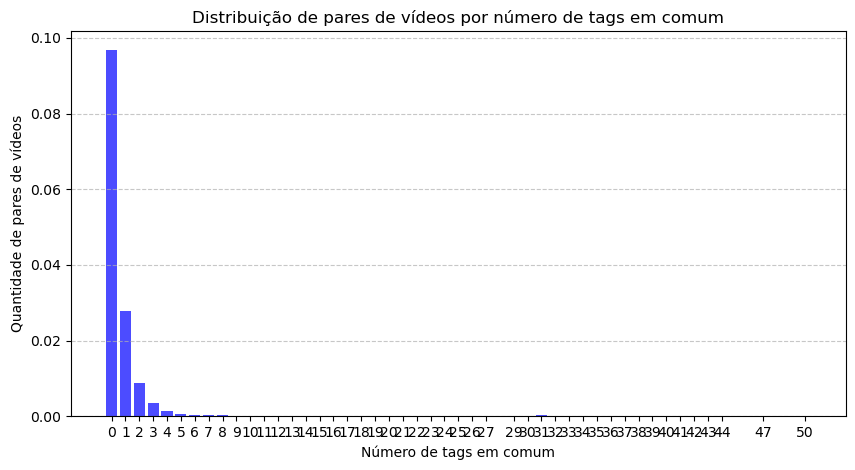

In [27]:
contador_tags = Counter()

# A função combinations é útil para iterar sobre pares
# se a ordem NÃO importa.
def tags_em_comum(tags1, tags2):
    return bool(set(tags1) & set(tags2))  # Retorna True se houver interseção
    
vert_totais = (vertices*vertices -1)/2

for u, v in combinations(dic.keys(), 2):
    common_tags = len(set(dic[u]) & set(dic[v]))  # Número de tags em comum
    # adiciona para fazer a grafico
    contador_tags[common_tags] += 1
        
x_values = sorted(contador_tags.keys())
y_values = [(contador_tags[x]/vert_totais)*100 for x in x_values]

# Criar gráfico
plt.figure(figsize=(10, 5))
plt.bar(x_values, y_values, color='b', alpha=0.7)
plt.xlabel("Número de tags em comum")
plt.ylabel("Quantidade de pares de vídeos")
plt.title("Distribuição de pares de vídeos por número de tags em comum")
plt.xticks(x_values)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



#### Quantidade de tags por vídeo

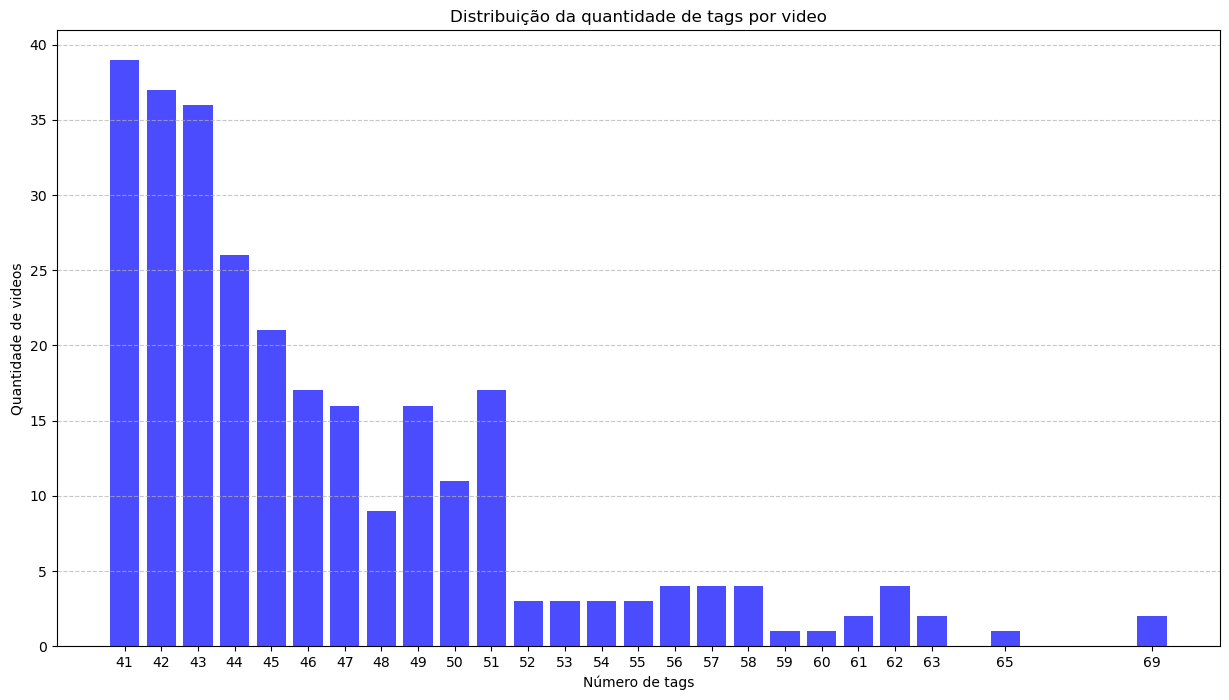

In [10]:
contador_tag_video = Counter()
for u in dic.keys():
    n = len(dic[u])
    contador_tag_video[n] += 1

x_values = sorted(contador_tag_video.keys())
y_values = [contador_tag_video[x] for x in x_values]

# Criar gráfico
plt.figure(figsize=(15, 8))
plt.bar(x_values, y_values, color='b', alpha=0.7)
plt.xlabel("Número de tags")
plt.ylabel("Quantidade de videos")
plt.title("Distribuição da quantidade de tags por video")
plt.xticks(x_values)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


    

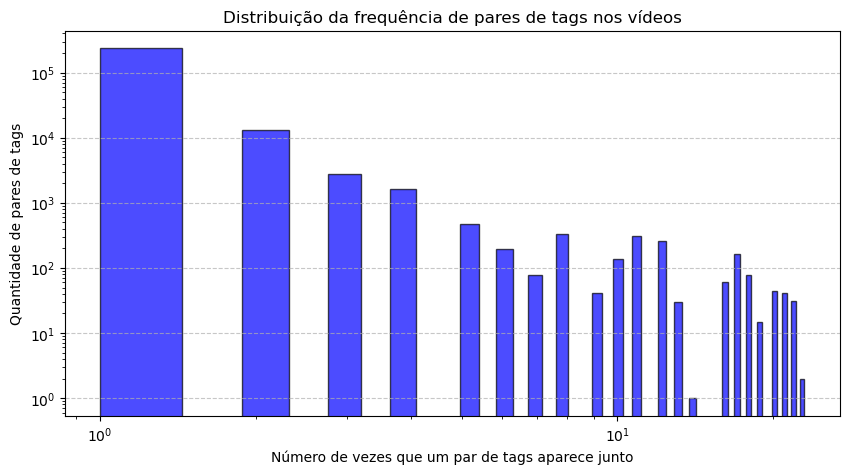

In [11]:
from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter

contador_pares = Counter()

# Para cada vídeo, gerar pares de tags e contar as ocorrências
for tags in dic.values():
    for tag1, tag2 in combinations(tags, 2):
        contador_pares[(tag1, tag2)] += 1

# Criar lista de contagens para o histograma
contagens = list(contador_pares.values())

# Criar gráfico de histograma
plt.figure(figsize=(10, 5))
plt.hist(contagens, bins=50, color='b', alpha=0.7, edgecolor="black")
plt.xlabel("Número de vezes que um par de tags aparece junto")
plt.ylabel("Quantidade de pares de tags")
plt.title("Distribuição da frequência de pares de tags nos vídeos")
plt.yscale("log")  # Escala logarítmica para melhor visualização
plt.xscale("log")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


#### REDE TWO MODE

In [12]:
# caso as tags apareçam juntas em mais de 10 videos, são ligadas
for (tag1, tag2), count in contador_pares.items():
    if count > 1:
        g.add_edge_by_ids(tag1, tag2)
        arestas+=1
            

In [13]:
print(f"Arestas (pares de tags ligadas que aparecem juntas em mais de 10 vídeos) {arestas}")

Arestas (pares de tags ligadas que aparecem juntas em mais de 10 vídeos) 19799


In [14]:
from graph_tool import draw
layout = draw.sfdp_layout(g)
# fazer clear
gte.move(g, layout)
g = gte.clean(g)
gte.save(g, 'two_mode_so_tags.net.gz')

HIBRIDA

Meus vértices são vídeos e tags, tags são ligadas entre si se possuem mais de 10 videos que a dupla aparece junta, vídeos são ligados com tag se eles a possuem. (Pegamos só vídeos que possuem mais de 40 tags)

In [15]:
# Grafo híbrido: vídeos e tags, conectados de formas diferentes
g_hibrida = gte.Graph(directed=False)

# Define a propriedade 'color' como um inteiro (para cores no formato 0xRRGGBB)
v_color = g_hibrida.new_vertex_property("int")
g_hibrida.vertex_properties["color"] = v_color  # Netpixi exige este nome

# Dicionários para armazenar os nomes dos vértices
vertex_names = {}
tag_id_to_nome = {}
arestas = 0

# Adicionando vídeos e tags como vértices e atribuindo cores e nomes
for video_id in dic.keys():
    # Adicionando o vídeo
    v = g_hibrida.vertex_by_id(video_id) if g_hibrida.vertex_by_id(video_id) else g_hibrida.add_vertex_by_id(video_id)
    v_color[v] = 0x33CCFF  # Cor azul claro para vídeos
    vertex_names[video_id] = f"Video_{video_id}"  # Salva o nome do vértice

    # Adicionando tags associadas ao vídeo
    for tag in dic[video_id]:
        t = g_hibrida.vertex_by_id(tag) if g_hibrida.vertex_by_id(tag) else g_hibrida.add_vertex_by_id(tag)
        v_color[t] = 0xFF66B2  # Cor rosa claro para tags
        vertex_names[tag] = f"Tag_{tag}"  # Salva o nome do vértice
        tag_id_to_nome[tag] = tag  # Mapeamento de tag para nome

        # Criando arestas entre vídeos e tags
        g_hibrida.add_edge_by_ids(video_id, tag)
        arestas += 1

# Agora, criando arestas entre tags que aparecem juntas em mais de 10 vídeos
for (tag1, tag2), count in contador_pares.items():
    if count > 1:  # Se as tags aparecem juntas em mais de 10 vídeos
        g_hibrida.add_edge_by_ids(tag1, tag2)
        arestas += 1

# Exibindo resultados
print(f"Rede híbrida salva com {g_hibrida.num_vertices()} vértices e {arestas} arestas.")




Rede híbrida salva com 7761 vértices e 32900 arestas.


In [ ]:
# Gerando o layout para visualização
from graph_tool import draw
layout = draw.sfdp_layout(g_hibrida)

# Fazendo o movimento do grafo de acordo com o layout
gte.move(g_hibrida, layout)

# Limpando o grafo
g_hibrida = gte.clean(g_hibrida)

# Salvando o grafo no formato .net.gz
gte.save(g_hibrida, 'hibrida.net.gz')

print(f"Grafo híbrido salvo como 'hibrida.net.gz'.")

Propriedades disponíveis: ['id', 'color', '_x', '_y']
Encontrados 281 vídeos no grafo
Colunas disponíveis no USvideos.csv: ['video_id', 'trending_date', 'title', 'channel_title', 'category_id', 'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'description']
Após junção: 1844 vídeos com dados completos

===== MODELO BASELINE (Degree) =====
                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     9.215
Date:                Wed, 21 May 2025   Prob (F-statistic):            0.00243
Time:                        13:27:55   Log-Likelihood:                -30602.
No. Observations:                1844   AIC:                         6.121e+04

/tmp/ipykernel_27/839494713.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Coeficiente: {modelo_base.params[1]}")
/tmp/ipykernel_27/839494713.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Valor-p: {modelo_base.pvalues[1]}")



===== MODELO COMPLETO (Degree + Log na dependente) =====
                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     25.85
Date:                Wed, 21 May 2025   Prob (F-statistic):           4.07e-07
Time:                        13:27:55   Log-Likelihood:                -3337.3
No. Observations:                1844   AIC:                             6679.
Df Residuals:                    1842   BIC:                             6690.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/tmp/ipykernel_27/839494713.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Coeficiente: {modelo_comp.params[1]}")
/tmp/ipykernel_27/839494713.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Valor-p: {modelo_comp.pvalues[1]}")


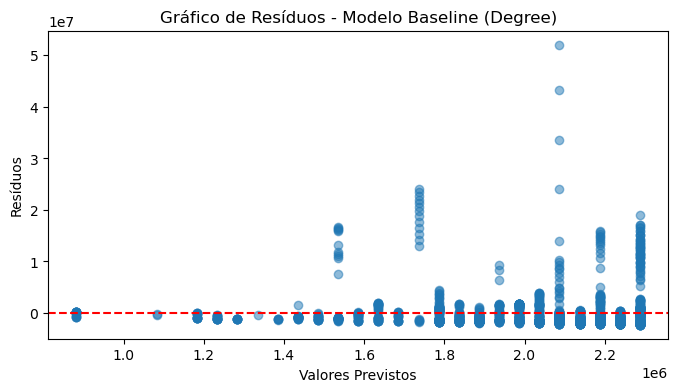

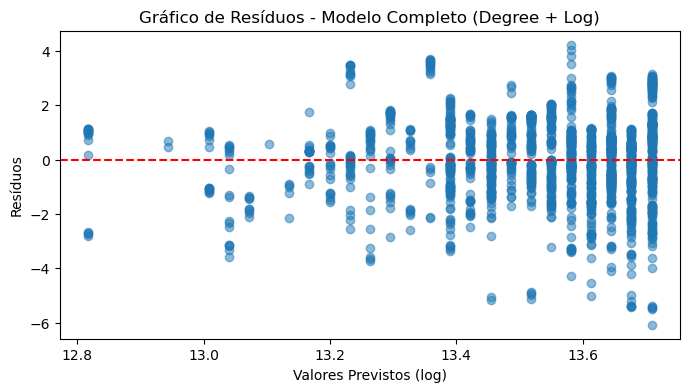

In [29]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import netpixi

# Carregar o grafo híbrido
g_hibrida = gte.load('./hibrida.net.gz')

# Verificar propriedades disponíveis
print("Propriedades disponíveis:", list(g_hibrida.vp.keys()))

# Extrair vídeos usando a cor como identificador (0x33CCFF = azul para vídeos)
videos = []
for v in g_hibrida.vertices():
    if 'color' in g_hibrida.vp and g_hibrida.vp.color[v] == 0x33CCFF:
        vid = g_hibrida.vp.id[v] if 'id' in g_hibrida.vp else v
        videos.append((v, vid))

print(f"Encontrados {len(videos)} vídeos no grafo")

# Calcular o grau de cada vídeo
graus = [(vid, g_hibrida.vertex(v).out_degree()) for v, vid in videos]
grau_df = pd.DataFrame(graus, columns=["video_id", "degree"])

# Carregar dados de visualizações
visualizacoes_df = pd.read_csv("./USvideos.csv")
print(f"Colunas disponíveis no USvideos.csv: {visualizacoes_df.columns.tolist()}")

# Converter para formato numérico
visualizacoes_df["views"] = pd.to_numeric(visualizacoes_df["views"], errors="coerce")

# Garantir compatibilidade de tipos
if grau_df["video_id"].dtype != visualizacoes_df["video_id"].dtype:
    if pd.api.types.is_numeric_dtype(grau_df["video_id"]):
        visualizacoes_df["video_id"] = pd.to_numeric(visualizacoes_df["video_id"])
    else:
        visualizacoes_df["video_id"] = visualizacoes_df["video_id"].astype(str)

# Juntar os dados
df_merged = pd.merge(grau_df, visualizacoes_df[["video_id", "views"]], on="video_id").dropna()
print(f"Após junção: {len(df_merged)} vídeos com dados completos")

# 1. MODELO BASELINE (original)
X_base = sm.add_constant(df_merged["degree"])
y_base = df_merged["views"]
modelo_base = sm.OLS(y_base, X_base).fit()

print("\n===== MODELO BASELINE (Degree) =====")
print(modelo_base.summary())
print(f"Coeficiente: {modelo_base.params[1]}")
print(f"Valor-p: {modelo_base.pvalues[1]}")
print(f"R-quadrado: {modelo_base.rsquared}")

# Gráfico de resíduos do modelo baseline
plt.figure(figsize=(8, 4))
plt.scatter(modelo_base.fittedvalues, modelo_base.resid, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores Previstos")
plt.ylabel("Resíduos")
plt.title("Gráfico de Resíduos - Modelo Baseline (Degree)")
plt.savefig('residuos_degree_baseline.png')

# 2. MODELO COMPLETO (com log na dependente)
X_comp = sm.add_constant(df_merged["degree"])
y_comp = np.log(df_merged["views"] + 1)  # Aplicando log na dependente
modelo_comp = sm.OLS(y_comp, X_comp).fit()

print("\n===== MODELO COMPLETO (Degree + Log na dependente) =====")
print(modelo_comp.summary())
print(f"Coeficiente: {modelo_comp.params[1]}")
print(f"Valor-p: {modelo_comp.pvalues[1]}")
print(f"R-quadrado: {modelo_comp.rsquared}")

# Gráfico de resíduos do modelo completo
plt.figure(figsize=(8, 4))
plt.scatter(modelo_comp.fittedvalues, modelo_comp.resid, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores Previstos (log)")
plt.ylabel("Resíduos")
plt.title("Gráfico de Resíduos - Modelo Completo (Degree + Log)")
plt.savefig('residuos_degree_completo.png')

plt.show()

Propriedades disponíveis: ['id', 'color', '_x', '_y', 'burt_constraint']
Encontrados 281 vídeos no grafo
Primeiras linhas dos dados de restrição:
      video_id  restricao
0  39idVpFF7NQ   0.045113
1  9wRQljFNDW8   0.037603
2  STI2fI7sKMo   0.023769
3  2VP846QcA_4   0.027001
4  qEEtzzi1EII   0.062348
Após junção: 1844 vídeos com dados completos

===== MODELO BASELINE (Restrição) =====
                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     46.53
Date:                Wed, 21 May 2025   Prob (F-statistic):           1.22e-11
Time:                        13:29:00   Log-Likelihood:                -30583.
No. Observations:                1844   AIC:                         6.117e+04
Df Residuals:                    1842   BIC:               

/tmp/ipykernel_27/2492600361.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Coeficiente: {modelo_base.params[1]}")
/tmp/ipykernel_27/2492600361.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Valor-p: {modelo_base.pvalues[1]}")



===== MODELO COMPLETO (Restrição + Log na dependente) =====
                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     76.10
Date:                Wed, 21 May 2025   Prob (F-statistic):           5.90e-18
Time:                        13:29:00   Log-Likelihood:                -3312.8
No. Observations:                1844   AIC:                             6630.
Df Residuals:                    1842   BIC:                             6641.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/tmp/ipykernel_27/2492600361.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Coeficiente: {modelo_comp.params[1]}")
/tmp/ipykernel_27/2492600361.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Valor-p: {modelo_comp.pvalues[1]}")


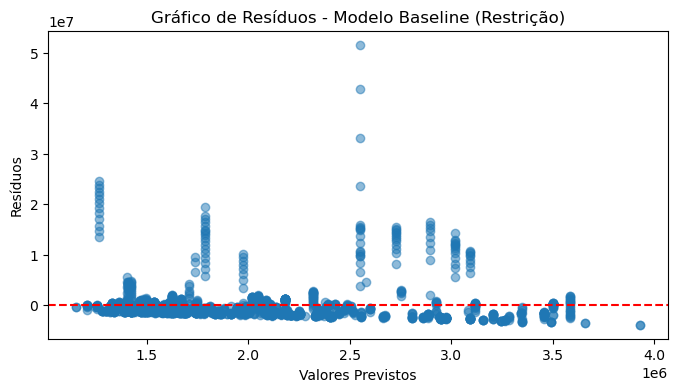

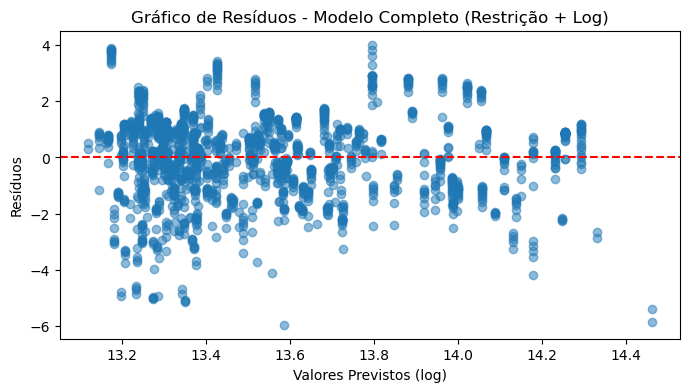

In [30]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import netpixi

# Carregar o grafo híbrido com restrição já calculada
g_hibrida = gte.load('./hibrida_com_restricao.net.gz')

# Verificar propriedades disponíveis
print("Propriedades disponíveis:", list(g_hibrida.vp.keys()))

# Extrair vídeos usando a cor como identificador (0x33CCFF = azul para vídeos)
videos = []
for v in g_hibrida.vertices():
    if 'color' in g_hibrida.vp and g_hibrida.vp.color[v] == 0x33CCFF:
        vid = g_hibrida.vp.id[v] if 'id' in g_hibrida.vp else v
        videos.append((v, vid))

print(f"Encontrados {len(videos)} vídeos no grafo")

# Extrair a restrição de cada vídeo
restricoes = []
for v, vid in videos:
    restricao = g_hibrida.vp.burt_constraint[v]
    restricoes.append((vid, restricao))

restricao_df = pd.DataFrame(restricoes, columns=["video_id", "restricao"])
print(f"Primeiras linhas dos dados de restrição:\n{restricao_df.head()}")

# Carregar dados de visualizações
visualizacoes_df = pd.read_csv("./USvideos.csv")

# Converter para formato numérico
visualizacoes_df["views"] = pd.to_numeric(visualizacoes_df["views"], errors="coerce")

# Garantir compatibilidade de tipos
if restricao_df["video_id"].dtype != visualizacoes_df["video_id"].dtype:
    if pd.api.types.is_numeric_dtype(restricao_df["video_id"]):
        visualizacoes_df["video_id"] = pd.to_numeric(visualizacoes_df["video_id"])
    else:
        visualizacoes_df["video_id"] = visualizacoes_df["video_id"].astype(str)

# Juntar os dados
df_merged = pd.merge(restricao_df, visualizacoes_df[["video_id", "views"]], on="video_id").dropna()
print(f"Após junção: {len(df_merged)} vídeos com dados completos")

# 1. MODELO BASELINE (original)
X_base = sm.add_constant(df_merged["restricao"])
y_base = df_merged["views"]
modelo_base = sm.OLS(y_base, X_base).fit()

print("\n===== MODELO BASELINE (Restrição) =====")
print(modelo_base.summary())
print(f"Coeficiente: {modelo_base.params[1]}")
print(f"Valor-p: {modelo_base.pvalues[1]}")
print(f"R-quadrado: {modelo_base.rsquared}")

# Gráfico de resíduos do modelo baseline
plt.figure(figsize=(8, 4))
plt.scatter(modelo_base.fittedvalues, modelo_base.resid, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores Previstos")
plt.ylabel("Resíduos")
plt.title("Gráfico de Resíduos - Modelo Baseline (Restrição)")
plt.savefig('residuos_restricao_baseline.png')

# 2. MODELO COMPLETO (com log na dependente)
X_comp = sm.add_constant(df_merged["restricao"])
y_comp = np.log(df_merged["views"] + 1)  # Aplicando log na dependente
modelo_comp = sm.OLS(y_comp, X_comp).fit()

print("\n===== MODELO COMPLETO (Restrição + Log na dependente) =====")
print(modelo_comp.summary())
print(f"Coeficiente: {modelo_comp.params[1]}")
print(f"Valor-p: {modelo_comp.pvalues[1]}")
print(f"R-quadrado: {modelo_comp.rsquared}")

# Gráfico de resíduos do modelo completo
plt.figure(figsize=(8, 4))
plt.scatter(modelo_comp.fittedvalues, modelo_comp.resid, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores Previstos (log)")
plt.ylabel("Resíduos")
plt.title("Gráfico de Resíduos - Modelo Completo (Restrição + Log)")
plt.savefig('residuos_restricao_completo.png')

plt.show()

In [27]:
import netpixi
h = netpixi.render("hibrida.net.gz", infinite=True);

#### MOSTRANDO A REDE TWO MODE

In [61]:
#import netpixi
#r = netpixi.render('two_mode_so_tags.net.gz', infinite=True);

#### Degree sobre a two-mode original

In [79]:
import netpixi
g = gte.load('./two_mode_so_tags.net.gz')
c = gte.total_degree(g)

g.add_vp('degree', c)

gte.save(g, 'degree.net.gz')


In [81]:
import netpixi
r_d = netpixi.render('degree.net.gz')

In [82]:
r_d.vertex_scale('degree', 10, 30)

#### Closeness sobre a two-mode original

In [93]:
import netpixi
g = gte.load('./two_mode_so_tags.net.gz')
c = centrality.closeness(g, harmonic=True)

g.add_vp('closeness', c)

gte.save(g, 'closeness.net.gz')

r_c = netpixi.render('closeness.net.gz')



In [84]:
r_c.vertex_scale('closeness', 10, 30)

In [102]:
g = gte.load('./closeness.net.gz')
top_5 = sorted(g.vertices(), key=lambda v: c[v], reverse=True)[:5]

# Exibir os resultados
print("Top 5 tags mais centrais (closeness):")
for v in top_5:
    print(f"{v}: {c[v]}")
    print(v["id"])

Top 5 tags mais centrais (closeness):
4: 1.0
Kate McKinnon
6: 1.0
live
8: 1.0
comedy
9: 1.0
sketch
10: 1.0
funny


#### Betweennes sobre a two-mode original

In [95]:
import netpixi
g = gte.load('./two_mode_so_tags.net.gz')
c, _ = centrality.betweenness(g)

g.add_vp('betweenness', c)

gte.save(g, 'betweenness.net.gz')

r_b = netpixi.render('betweenness.net.gz')



In [87]:
r_b.vertex_scale('betweenness', 10, 30)

In [101]:
g = gte.load('./betweenness.net.gz')
top_5 = sorted(g.vertices(), key=lambda v: c[v], reverse=True)[:5]

# Exibir os resultados
print("Top 5 tags (betweennes):")
for v in top_5:
    print(f"{v}: {c[v]}")
    print(v["id"])


Top 5 tags (betweennes):
4: 1.0
Kate McKinnon
6: 1.0
live
8: 1.0
comedy
9: 1.0
sketch
10: 1.0
funny


In [ ]:
print(list(g.vp.keys()))

['id', '_x', '_y', 'betweenness']


#### Mostrando a Rede Hibrida

In [9]:
import netpixi
g = gte.load('./hibrida.net.gz')
# número de vértices
n_vertices = g.num_vertices()

# número de arestas
n_arestas  = g.num_edges()

print(f"Vértices: {n_vertices}, Arestas: {n_arestas}")

r_hd = netpixi.render('hibrida.net.gz')

FileNotFoundError: [Errno 2] No such file or directory: './hibrida.net.gz'

#### Degree sobre a hibrida

In [97]:
import netpixi
g_hibrida = gte.load('./hibrida.net.gz')
c = gte.total_degree(g_hibrida)

g_hibrida.add_vp('degree', c)

gte.save(g_hibrida, 'degree_hibrida.net.gz')

r_hd = netpixi.render('degree_hibrida.net.gz')

In [16]:
import netpixi
r_hd = netpixi.render('degree_hibrida.net.gz')

In [20]:
r_hd.vertex_scale('degree', 10, 30)

In [100]:
g = gte.load('./degree_hibrida.net.gz')
top_5 = sorted(g.vertices(), key=lambda v: c[v], reverse=True)[:5]

# Exibir os resultados
print("Top 5 tags (degree):")
for v in top_5:
    print(f"{v}: {c[v]}")
    print(v["id"])

Top 5 tags (degree):
4: 1.0
Episode 1730
6: 1.0
Roy Moore
8: 1.0
Mike Pence
9: 1.0
Beck Bennett
10: 1.0
Jeff Sessions


#### Restrição sobre a rede hibrida

In [99]:
import netpixi
g = gte.load('./hibrida.net.gz')

c = gte.burt_constraint(g)

g.add_vp('burt_constraint', c)

#gte.save(g, 'structural_holes.net.gz')



In [14]:
import netpixi
r_s = netpixi.render('structural_holes.net.gz')

In [15]:
r_s.vertex_scale('burt_constraint', 10, 30)

In [104]:
g = gte.load('./structural_holes.net.gz')

top_5 = sorted(g.vertices(), key=lambda v: c[v], reverse=True)[:5]

# Exibir os resultados
print("Top 5 tags (restrição):")
for v in top_5:
    print(f"{v}: {c[v]}")
    print(v["id"])

Top 5 tags (restrição):
4: 1.0
Episode 1730
6: 1.0
Roy Moore
8: 1.0
Mike Pence
9: 1.0
Beck Bennett
10: 1.0
Jeff Sessions
